# Lab Three: Extending Logistic Regression
 

#### Everett Cienkus, Blake Miller, Colin Weil

### 1. Preparation and Overview

#### 1.1 Business Case

   This data set is a collection of data on the specs of light seen in the night sky. This data was collected by the Sloan Digital Sky Survey (SDSS) is a collection of 100,000 observations. There are 17 feature columns comprised of different spectral characteristics and one classification column that classifies the member of the dataset as either a star, galaxy, or quasar. This data is collected using large-scale telescopes owned by the SDSS and their observations are recorded by the employees. The SDSS is an organization that is funded by the Alfred P. Sloan Foundation, The National Science Foundation, and The US Department of Energy Office of Science meaning the collection of this data is also supported and endorsed by the government. 
    
   The classification task for this dataset would be to figure out if the member of the dataset is a star, galaxy, or quasar based on the 17 specter characteristics. According to the SDSS, they have been able to create a 3D map of 1/3 of the night sky with 2/3 of the sky left to map. They have accomplished a great amount since they started, but the classification process takes a long time. After collecting all the data from the telescope, they need to back over the data to try and classify what they observed. With our classification algorithm, they could collect the data and get a classification while still working within the telescope. Not only would this cut down on the time spent classifying the data themselves, but they could also draw further conclusions from a cluster they are observing because they know what it is. With the SDSS’s funding from the government, there is a desire to get all the night sky mapped and the investment into this mapping is already established. This classification task would be beneficial to the SDSS and could be priced at the money saved from not needing to pay the team of people for the hours they would have spent classifying the lights in the sky. They would still need to collect all of the data, but the classification model would do the rest. 

   There are a number of different classification models that have been used to analyze and classify different stars in the Morgan-Keenan star classification dataset. This dataset consists of different characteristics of a star like effective temperature and luminosity to classify the type of star. All these different models worked well on the dataset, but they found that they could achieve the highest accuracy when they combined the models. They claimed that creating a hybrid of all the models allowed the classification to be more versatile and achieve a success rate of 80%. This data set is similar to the one we are using to the point where we can use their success rate as a benchmark for our own. To prove that our classification method is ahead of others and at the forefront of stellar classification we need to have a success rate above 80%. This is the rate that would convince the SDSS that our classification model is the best one to help their company efficiency finish their 3d mapping the last 2/3 of the night sky.
    
Information about the specifics of this dataset and more can be found at the following links. 

https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17 

https://www.sdss.org/

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7517012/


Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the classification task is and what parties would be interested in the results. For example, would the model be deployed or used mostly for offline analysis? 

#### 1.2 Preparation of Data

In [80]:
import pandas as pd
import numpy as np

# Define and prepare your class variables.
df = pd.read_csv('star_dataset/star_classification.csv')
df = df.dropna()

X = df.drop(columns = ['obj_ID','run_ID','rerun_ID','field_ID','spec_obj_ID', 'MJD', 'class','plate', 'fiber_ID','cam_col' ])
#X = df.drop(columns = ['obj_ID','run_ID','rerun_ID','field_ID','spec_obj_ID', 'MJD', 'class'])
y = df['class']

# Use proper variable representations (int, float, one-hot, etc.).
# Use pre-processing methods (as needed) for dimensionality reduction, 
# scaling, etc. Remove variables that are not needed/useful for the analysis. 
# Describe the final dataset that is used for classification/regression
display(X.info())
display(y.info())
# (include a description of any newly formed variables you created).
# MAKE SURE TO NORMALIZE VALUES

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alpha     100000 non-null  float64
 1   delta     100000 non-null  float64
 2   u         100000 non-null  float64
 3   g         100000 non-null  float64
 4   r         100000 non-null  float64
 5   i         100000 non-null  float64
 6   z         100000 non-null  float64
 7   redshift  100000 non-null  float64
dtypes: float64(8)
memory usage: 6.1 MB


None

<class 'pandas.core.series.Series'>
RangeIndex: 100000 entries, 0 to 99999
Series name: class
Non-Null Count   Dtype 
--------------   ----- 
100000 non-null  object
dtypes: object(1)
memory usage: 781.4+ KB


None

Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

#### 1.3 Division of Trainig and Testing Data

In [81]:
# Divide your data into training and testing data using an 80% training 
# and 20% testing split. Use the cross validation modules that are part 
# of scikit-learn.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, train_size=0.8)

unique_ytrain, counts_ytrain = np.unique(y_train, return_counts=True)
print(np.asarray((unique_ytrain, counts_ytrain)).T)

[['GALAXY' 47637]
 ['QSO' 15129]
 ['STAR' 17234]]


Argue "for" or "against" splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset?  

In [82]:
### 2. Modeling

#### 2.1 One-Versus-All Logistic Regression Classifier

In [83]:
from scipy.special import expit
from sklearn.metrics import accuracy_score

def regularize(w, c, reg):
    if reg == 'L2':
        return -2 * w[1:] * c
    if reg == 'L1':
        return  - w[1:] / abs(w[1:]) * c
    if reg == "both":
        return regularize(w, c, 'L2') + regularize(w, c, 'L1')
    else:
        return 0

class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001, reg ="L2"):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.reg = reg
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'

    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term

    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))

    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through

        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += regularize(w= self.w_, c = self.C, reg=self.reg)

        return gradient

    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1

    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction

    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros

        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate
            # add bacause maximizing

class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through

        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += regularize(w= self.w_, c = self.C, reg=self.reg)

        return gradient

# for this, we won't perform our own BFGS implementation
# (it takes a fair amount of code and understanding, which we haven't setup yet)
# luckily for us, scipy has its own BFGS implementation:
from scipy.optimize import fmin_bfgs # maybe the most common bfgs algorithm in the world
from numpy import ma
np.seterr(invalid='ignore')
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):

    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        # invert this because scipy minimizes, but we derived all formulas for maximzing
        return -np.sum(ma.log(g[y==1]))-np.sum(ma.log(1-g[y==0])) + C*sum(w**2)
        #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    def objective_gradient(self,w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += regularize(w= w, c = C, reg=self.reg)
        return -gradient

    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)

        self.w_ = self.w_.reshape((num_features,1))


class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20,
                 C=0.0001,
                 solver=BFGSBinaryLogisticRegression, reg ="L2"):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.solver = solver
        self.classifiers_ = []
        self.reg = reg
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'

    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = np.array(y==yval).astype(int) # create a binary problem

            # train the binary classifier for this class

            hblr = self.solver(eta=self.eta,iterations=self.iters,C=self.C, reg=self.reg)
            hblr.fit(X,y_binary)

            # add the trained classifier to the list
            self.classifiers_.append(hblr)

        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier

        return np.hstack(probs) # make into single matrix

    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row

### Steepest Ascent

In [84]:
%%time
lr = MultiClassLogisticRegression(eta=0.05,
                                  iterations=1000,
                                  C=0.0001,
                                  solver=BinaryLogisticRegression,
                                  reg="L2"
                                  )
#np.hstack((np.ones((X.shape[0],1)),X))
lr.fit(X_train,y_train)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))
unique_yhat, counts_yhat = np.unique(yhat, return_counts=True)
unique_y, counts_y = np.unique(y_test, return_counts=True)
print(np.asarray((unique_yhat, counts_yhat)).T)
print(np.asarray((unique_y, counts_y)).T)

Accuracy of:  0.5909
[['GALAXY' 19989]
 ['QSO' 11]]
[['GALAXY' 11808]
 ['QSO' 3832]
 ['STAR' 4360]]
CPU times: total: 1min 15s
Wall time: 21.6 s


### Stochastic gradient Ascent

In [85]:
%%time
lr = MultiClassLogisticRegression(eta=0.05,
                                  iterations=1000,
                                  C=0.0001,
                                  solver=StochasticLogisticRegression,
                                  reg="none"
                                  )
#np.hstack((np.ones((X.shape[0],1)),X))
lr.fit(X_train,y_train)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))
unique_yhat, counts_yhat = np.unique(yhat, return_counts=True)
unique_y, counts_y = np.unique(y_test, return_counts=True)
print(np.asarray((unique_yhat, counts_yhat)).T)
print(np.asarray((unique_y, counts_y)).T)

Accuracy of:  0.5766
[['GALAXY' 18783]
 ['QSO' 649]
 ['STAR' 568]]
[['GALAXY' 11808]
 ['QSO' 3832]
 ['STAR' 4360]]
CPU times: total: 688 ms
Wall time: 172 ms


### BFGS

In [86]:
%%time
lr = MultiClassLogisticRegression(eta=1,
                                  iterations=10,
                                  C=0.00001,
                                  solver=BFGSBinaryLogisticRegression,
                                  reg='L2'
                                  )
#np.hstack((np.ones((X.shape[0],1)),X))
lr.fit(X_train,y_train)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))
unique_yhat, counts_yhat = np.unique(yhat, return_counts=True)
unique_y, counts_y = np.unique(y_test, return_counts=True)
print(np.asarray((unique_yhat, counts_yhat)).T)
print(np.asarray((unique_y, counts_y)).T)

Accuracy of:  0.8567
[['GALAXY' 12470]
 ['QSO' 3664]
 ['STAR' 3866]]
[['GALAXY' 11808]
 ['QSO' 3832]
 ['STAR' 4360]]
CPU times: total: 6.41 s
Wall time: 1.59 s


#### 2.2 Training Classifier for Good Generalization Performance

Accuracy of C= 0.01  : 0.83915
Accuracy of C= 0.001  : 0.86535
Accuracy of C= 0.0001  : 0.88885
Accuracy of C= 1e-05  : 0.9187
Accuracy of C= 1.0000000000000002e-06  : 0.9407
Accuracy of C= 1.0000000000000001e-07  : 0.94265
Accuracy of C= 1e-08  : 0.9426
Accuracy of C= 1e-09  : 0.94265
Accuracy of C= 1e-10  : 0.94265
Accuracy of C= 1.0000000000000001e-11  : 0.94265


C:\Users\tallb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


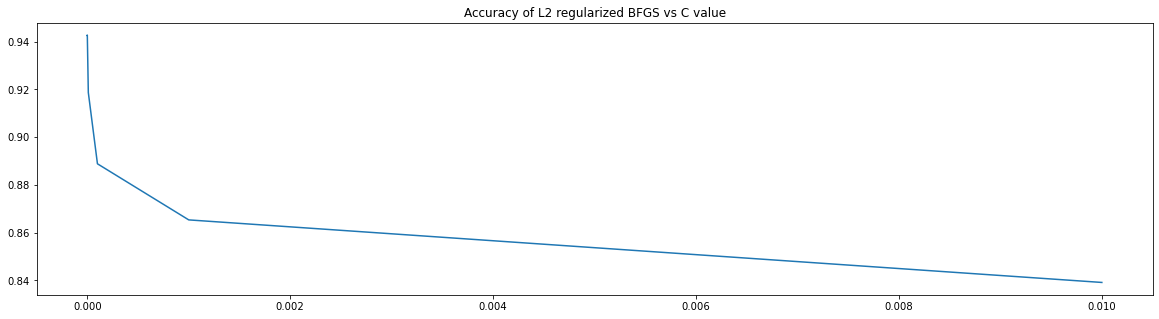

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
c = []
acc = []
for i in range(10):

    lr = MultiClassLogisticRegression(eta=.5,
                                      iterations=45,
                                      C=.01*(10**(-i)),
                                      solver=BFGSBinaryLogisticRegression,
                                      reg='L2'
                                      )
    lr.fit(X_train,y_train)
    yhat = lr.predict(X_test)
    c.append(.01*(10**(-i)))
    acc.append(accuracy_score(y_test,yhat))
    print('Accuracy of C=',.01*(10**(-i))," :",accuracy_score(y_test,yhat))
plt.subplots(figsize=(20, 5))
plt.subplot(1,1,1)
sns.lineplot(c, acc)
plt.title("Accuracy of L2 regularized BFGS vs C value")
plt.show()

Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?

#### 2.3 Comparing Best Performing Procedure to Scikit-Learn

In [88]:
%%time
from sklearn.linear_model import LogisticRegression as SKLogisticRegression

lr_sk = SKLogisticRegression(solver='liblinear') # all params default

lr_sk.fit(X,y)
#print(np.hstack((lr_sk.intercept_[:,np.newaxis],lr_sk.coef_)))
yhat = lr_sk.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))

Accuracy of:  0.93088
CPU times: total: 6.88 s
Wall time: 6.71 s


C:\Users\tallb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [89]:
# Visualize the performance differences in terms of training time and classification performance.

Discuss the results. 

### 3. Deployment

Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party)? Why?

### 4. BFGS (Can change but thought this would be better)

In [90]:
# Implementation of BFGS

In [91]:
# SciPy Implementation from Class
bfgslr = BFGSBinaryLogisticRegression(_,iterations=2,C=0.001) # note that we need only a few iterations here

y.replace(to_replace=['GALAXY','QSO','STAR'],
               value=range(3),
               inplace=True)
y_array = y.to_numpy()

In [92]:
%%time
lr = MultiClassLogisticRegression(eta=1,
                                  iterations=10,
                                  C=0.01,
                                  solver=BFGSBinaryLogisticRegression
                                 )
lr.fit(X,y_array)
print(lr)

yhat = lr.predict(X)
print('Accuracy of: ',accuracy_score(y_array,yhat))

MultiClass Logistic Regression Object with coefficients:
[[-1.54239029e-02 -6.81398213e-05 -4.15153507e-03  1.95887121e-01
   8.77170823e-01 -2.35135872e-02 -4.76081953e-01 -6.41194520e-01
  -3.24682398e-01]
 [-1.10964724e-01  4.43817465e-04  5.58618068e-03 -8.16593320e-01
  -9.68819633e-02 -2.24737586e-01  1.34434195e-01  9.67964400e-01
   1.72763866e+00]
 [ 8.95451545e-02 -5.85004280e-04 -7.54851412e-04  5.51604520e-02
  -7.03408820e-01  5.95210651e-03  2.35070818e-01  4.29899447e-01
  -1.95164632e+00]]
Accuracy of:  0.84167
CPU times: total: 8.06 s
Wall time: 2.04 s
